In [166]:
import os
from copy import deepcopy
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

import catboost as cb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold

In [167]:
train = pd.read_csv("data/ieee-fraud-detection/assignment_train.csv")
test = pd.read_csv("data/ieee-fraud-detection/assignment_test.csv")
train.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


__Задание 1:__ Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

Text(0.5, 0, 'TransactionDT')

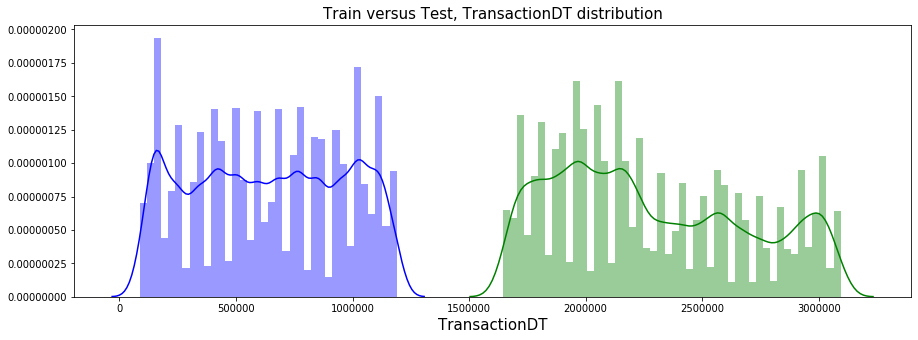

In [168]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes.set_title("Train versus Test, TransactionDT distribution", fontsize=15)
sns.distplot(train["TransactionDT"], ax=axes, color="blue", label="train")
sns.distplot(test["TransactionDT"], ax=axes, color="green", label="test")
axes.set_xlabel("TransactionDT", fontsize=15)

Признак `TransactionDT` представляет собой разницу времени от заданного времени и времени совершения транзакции. Одним из первых инсайтов из данных может быть, что обучающая и тестовая выборка, по-видимому, разделены по времени. Между ними есть небольшой промежуток, но в целом, обучающая выборка относится к более раннему периоду времени, а тест - к более позднему периоду времени. Это может являться сигналом к тому, чтобы провести валидацию по времени. Мы рассмотрим это подробнее при рассмотрении различий в распределении признаков между обучением и тестом.

__Задание 2:__ построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

(0, 5000)

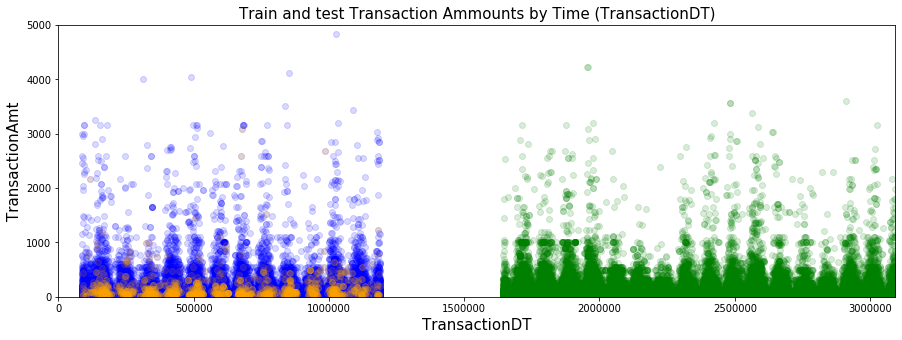

In [169]:
fig = plt.figure(figsize=(15, 5))
plt.title("Train and test Transaction Ammounts by Time (TransactionDT)", size=15)
plt.scatter(train["TransactionDT"], train["TransactionAmt"], alpha=0.15, color="blue")
plt.scatter(train.loc[train["isFraud"]==1, "TransactionDT"], train.loc[train["isFraud"]==1, "TransactionAmt"], alpha=0.15, color="orange")
plt.scatter(test["TransactionDT"], test["TransactionAmt"], alpha=0.15, color="green")
plt.xlim(0, test["TransactionDT"].max())
plt.ylabel("TransactionAmt", size=15)
plt.xlabel("TransactionDT", size=15)
plt.ylim(0, 5000)

Признак `TransactionAmt` интересно распределн в соответствии с `TransactionDT`. В основном, большая часть мошеннических операций сосредоточена на маленьких суммах, что является не удивительным. Кажется, что мошенничество на маленькие суммы оправдано, поскольку клиенты могут этого не заметить / не захотеть обращаться в банк для претензионной работы. При этом, мошеннические операции имеют явную периодичность: возможно, мошенничество совершается, по большей часте, по будням.

__Задание 3:__ построить распределение признака `TransactionAmt` в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

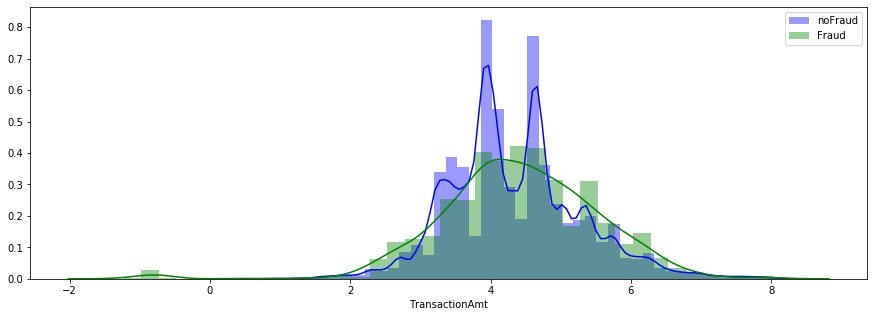

In [170]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
sns.distplot(np.log(train.loc[train["isFraud"]==0, "TransactionAmt"]), color="Blue", label="noFraud")
sns.distplot(np.log(train.loc[train["isFraud"]==1, "TransactionAmt"]), color="Green", label="Fraud")
plt.legend()

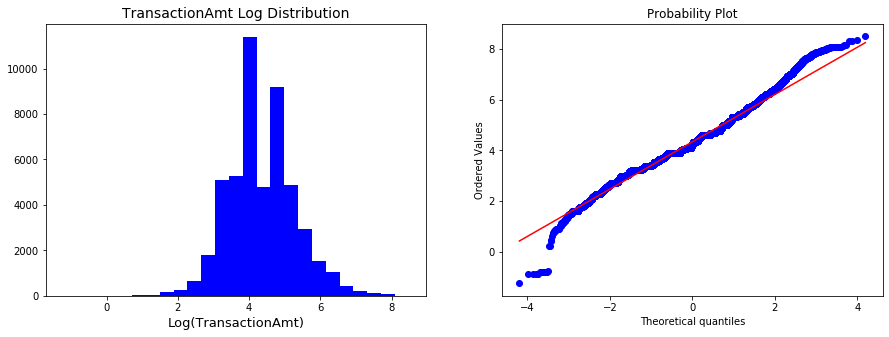

In [171]:
transaction_amt_log = np.log(train["TransactionAmt"])

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title("TransactionAmt Log Distribution", fontsize=14)
axes[0].set_xlabel("Log(TransactionAmt)", fontsize=13)
axes[0].hist(transaction_amt_log, bins=25, color="blue")
probplot(transaction_amt_log, plot=axes[1])
plt.show()

Будем использовать логарифмическое преобразование признаков, чтобы лучше проанализировать распределение признака `TransactionAmt`, поскольку распределение исходного признака сильно скошено. Распределение `TransactionAmt` в разрезе целевой переменной демонстрирует явное отличие распределений. Распределение объектов фонового класса является более узким, более кучно сосредоточены вокруг среднего значения логарифмированного признака. Распределение логарифмированной переменной не является нормальным, QQ-график выглядит сильно отличным от графика нормального распределения.

__Задание 4:__ построить распределение признака целевой переменной в зависимости от значений категориальных признаков `ProductCD`, `card4`, `card6`. Сделать выводы.

Признак `ProductCD`:
* достоверно неизвестно, что означает данный признак, мы можем только предполагать
* Значение `W` - наиболее распространенное, значение `S` - наименее распространенное
* `ProductCD` равный `C` имеет наибольший уровень мошенничества (практически 10%)
* `ProductCD` равный `H` имеет меньше 2% уровня мошенничества


Text(0, 0.5, 'count')

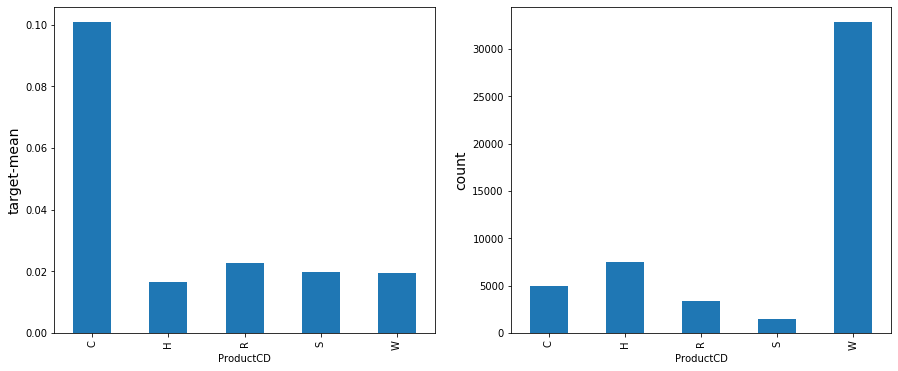

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train.groupby(["ProductCD"])["isFraud"].mean().plot(kind="bar", ax=axes[0])
train.groupby(["ProductCD"])["isFraud"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

Text(0, 0.5, 'count')

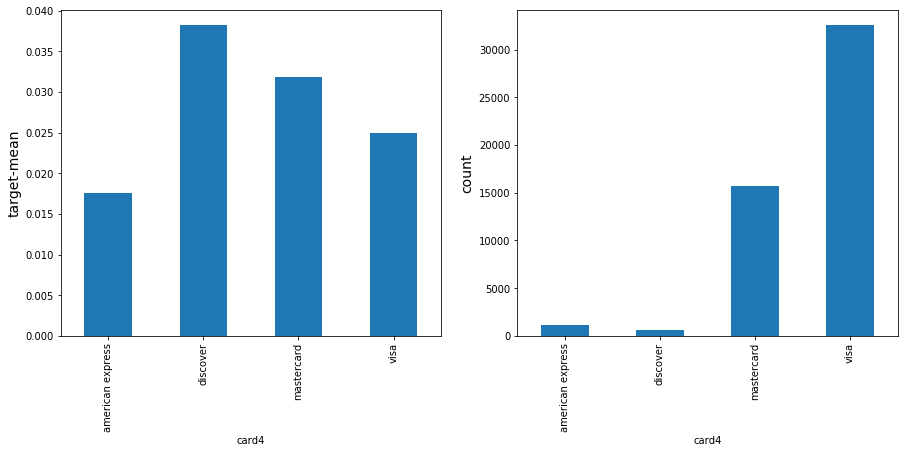

In [173]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train.groupby(["card4"])["isFraud"].mean().plot(kind="bar", ax=axes[0])
train.groupby(["card4"])["isFraud"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

Text(0, 0.5, 'count')

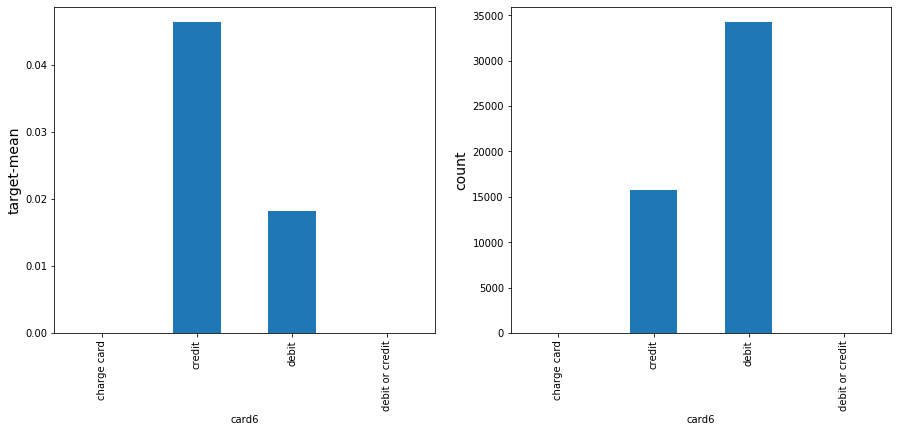

In [174]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train.groupby(["card6"])["isFraud"].mean().plot(kind="bar", ax=axes[0])
train.groupby(["card6"])["isFraud"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

## Основное задание

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче.


##  Hold-Out валидация на 2 выборки

__Задание 1:__ сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (`TransactionID`), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [ ]:
train -> x_train / x_valid / x_test
# test - имитация public LB -> public_lb

In [179]:
def fit_catboost(x_train, y_train, model_params, categorical, *args):
    """
    Обучение модели CatBoostClassifier.

    Parameters
    ----------
    x_train: pandas.core.frame.DataFrame
        Матрица признаков для обучения модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для валидации модели.

    model_params: dict
        Словарь со значением гиперпараметров модели.

    categorical: List[str]
        Список с названием категориальных признаков.

    Returns
    -------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    """
    eval_set = [(x_train, y_train)]

    if args == 2:
        eval_set.append((args[0], args[1]))

    model = cb.CatBoostClassifier(**model_params)
    model.fit(
        X=x_train,
        y=y_train,
        eval_set=eval_set,
        cat_features=categorical
    )

    return model

def evaluate_model(model, *args):
    """
    Оценка качества модели.

    Parameters
    ----------
    model: catboost.core.CatBoostClassifier
        Экземпляр обученного классификатора.

    args: pandas.core.frame.DataFrame
        Пары из обучающей выборки и вектора истинных ответов.
        Опциональные параметры.

    """
    eval_data = [(args[i], args[i+1]) for i in range(0, len(args), 2)]
    if eval_data:
        for sample, target in eval_data:
            y_pred = model.predict_proba(sample)[:, 1]
            score = roc_auc_score(target, y_pred)
            print(f"score = {round(score, 6)}")

def prepare_data(X, categorical, to_drop):
    """
    Преобразование данных для передачи в модель.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков для передачи в модель.

    categorical: List[str]
        Список с названием категориальных признаков.

    drop_features: List[str]
        Список с названием признаков, которые не должны
        участвовать в обучении.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Матрица признаков, подготовленная для передачи в модель.

    """
    X_transformed = X.copy()
    to_drop = set(X.columns) & set(to_drop)

    if to_drop:
        X_transformed = X_transformed.drop(to_drop, axis=1)

    X_transformed[categorical] = X_transformed[categorical].astype(str)
    return X_transformed

In [180]:
to_drop = [
    "TransactionID",
    "TransactionDT",
    "isFraud",
]

categorical = train.select_dtypes(include=["object"]).columns.tolist()

In [181]:
x_train, x_valid = train_test_split(
    train, train_size=0.7, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.7, random_state=27, shuffle=True
)

In [182]:
x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_public_lb.shape))

x_train.shape = 35000 rows, 391 cols
x_valid.shape = 15001 rows, 391 cols
x_test.shape = 75000 rows, 391 cols


In [183]:
cb_params_1000 = {
    "n_estimators": 1000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.6253433	best: 0.6253433 (0)	total: 54ms	remaining: 54s
10:	test: 0.7847311	best: 0.7847311 (10)	total: 612ms	remaining: 55.1s
20:	test: 0.7994185	best: 0.8016245 (19)	total: 1.21s	remaining: 56.3s
30:	test: 0.7988680	best: 0.8016245 (19)	total: 1.73s	remaining: 54.1s
40:	test: 0.8043326	best: 0.8043686 (39)	total: 2.28s	remaining: 53.4s
50:	test: 0.8125015	best: 0.8125258 (49)	total: 2.87s	remaining: 53.4s
60:	test: 0.8155623	best: 0.8159064 (58)	total: 3.43s	remaining: 52.8s
70:	test: 0.8194678	best: 0.8194678 (70)	total: 3.95s	remaining: 51.7s
80:	test: 0.8234972	best: 0.8237215 (75)	total: 4.49s	remaining: 51s
90:	test: 0.8245154	best: 0.8251142 (88)	total: 5.02s	remaining: 50.1s
100:	test: 0.8310474	best: 0.8310474 (100)	total: 5.58s	remaining: 49.6s
110:	test: 0.8350225	best: 0.8350272 (106)	total: 6.14s	remaining: 49.2s
120:	test: 0.8411187	best: 0.8411187 (120)	total: 6.76s	remaining: 49.1s
130:	test: 0.8478842	best: 0.8478842 (130)	total: 7.3s	remaining: 48.4s
140:	t

In [184]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

score = 0.896207
score = 0.869308
score = 0.866614


In [185]:
cb_params_10000 = {
    "n_estimators": 10000,
    "learning_rate": 0.01,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 27
}

model = fit_catboost(
    x_train, y_train, cb_params_10000, categorical, x_valid, y_valid)

0:	test: 0.6253433	best: 0.6253433 (0)	total: 62.6ms	remaining: 10m 25s
10:	test: 0.7847311	best: 0.7847311 (10)	total: 697ms	remaining: 10m 32s
20:	test: 0.7994185	best: 0.8016245 (19)	total: 1.28s	remaining: 10m 10s
30:	test: 0.7988680	best: 0.8016245 (19)	total: 1.92s	remaining: 10m 18s
40:	test: 0.8043326	best: 0.8043686 (39)	total: 2.54s	remaining: 10m 16s
50:	test: 0.8125015	best: 0.8125258 (49)	total: 3.13s	remaining: 10m 11s
60:	test: 0.8155623	best: 0.8159064 (58)	total: 3.95s	remaining: 10m 43s
70:	test: 0.8194678	best: 0.8194678 (70)	total: 4.56s	remaining: 10m 38s
80:	test: 0.8234972	best: 0.8237215 (75)	total: 5.21s	remaining: 10m 37s
90:	test: 0.8245154	best: 0.8251142 (88)	total: 5.96s	remaining: 10m 49s
100:	test: 0.8310474	best: 0.8310474 (100)	total: 6.72s	remaining: 10m 58s
110:	test: 0.8350225	best: 0.8350272 (106)	total: 7.36s	remaining: 10m 56s
120:	test: 0.8411187	best: 0.8411187 (120)	total: 8.16s	remaining: 11m 6s
130:	test: 0.8478842	best: 0.8478842 (130)	tota

1100:	test: 0.8977290	best: 0.8977290 (1100)	total: 1m 17s	remaining: 10m 24s
1110:	test: 0.8978089	best: 0.8978089 (1110)	total: 1m 17s	remaining: 10m 23s
1120:	test: 0.8978986	best: 0.8978986 (1120)	total: 1m 18s	remaining: 10m 22s
1130:	test: 0.8979832	best: 0.8979832 (1130)	total: 1m 19s	remaining: 10m 21s
1140:	test: 0.8982217	best: 0.8982217 (1140)	total: 1m 19s	remaining: 10m 20s
1150:	test: 0.8982480	best: 0.8982480 (1150)	total: 1m 20s	remaining: 10m 20s
1160:	test: 0.8982918	best: 0.8982918 (1160)	total: 1m 21s	remaining: 10m 19s
1170:	test: 0.8985832	best: 0.8985832 (1170)	total: 1m 22s	remaining: 10m 19s
1180:	test: 0.8987165	best: 0.8987166 (1179)	total: 1m 22s	remaining: 10m 18s
1190:	test: 0.8989029	best: 0.8989029 (1190)	total: 1m 23s	remaining: 10m 17s
1200:	test: 0.8990609	best: 0.8990609 (1200)	total: 1m 24s	remaining: 10m 16s
1210:	test: 0.8991264	best: 0.8991264 (1210)	total: 1m 24s	remaining: 10m 16s
1220:	test: 0.8991956	best: 0.8991956 (1220)	total: 1m 25s	remai

2170:	test: 0.9051026	best: 0.9051026 (2170)	total: 2m 34s	remaining: 9m 15s
2180:	test: 0.9051787	best: 0.9051787 (2180)	total: 2m 34s	remaining: 9m 14s
2190:	test: 0.9052940	best: 0.9052940 (2190)	total: 2m 35s	remaining: 9m 13s
2200:	test: 0.9053167	best: 0.9053167 (2200)	total: 2m 35s	remaining: 9m 12s
2210:	test: 0.9053461	best: 0.9053467 (2209)	total: 2m 36s	remaining: 9m 11s
2220:	test: 0.9053887	best: 0.9053896 (2217)	total: 2m 37s	remaining: 9m 10s
2230:	test: 0.9056420	best: 0.9056425 (2228)	total: 2m 37s	remaining: 9m 9s
2240:	test: 0.9056615	best: 0.9056615 (2240)	total: 2m 38s	remaining: 9m 8s
2250:	test: 0.9057134	best: 0.9057134 (2250)	total: 2m 39s	remaining: 9m 7s
2260:	test: 0.9057800	best: 0.9057801 (2259)	total: 2m 39s	remaining: 9m 6s
2270:	test: 0.9059057	best: 0.9059057 (2270)	total: 2m 40s	remaining: 9m 5s
2280:	test: 0.9059612	best: 0.9059612 (2280)	total: 2m 41s	remaining: 9m 4s
2290:	test: 0.9060227	best: 0.9060231 (2288)	total: 2m 41s	remaining: 9m 4s
2300:	

3250:	test: 0.9134066	best: 0.9134070 (3249)	total: 3m 48s	remaining: 7m 53s
3260:	test: 0.9134294	best: 0.9134294 (3258)	total: 3m 48s	remaining: 7m 52s
3270:	test: 0.9134976	best: 0.9134977 (3268)	total: 3m 49s	remaining: 7m 52s
3280:	test: 0.9135236	best: 0.9135236 (3278)	total: 3m 50s	remaining: 7m 51s
3290:	test: 0.9135338	best: 0.9135338 (3290)	total: 3m 50s	remaining: 7m 50s
3300:	test: 0.9135450	best: 0.9135450 (3299)	total: 3m 51s	remaining: 7m 49s
3310:	test: 0.9135607	best: 0.9135608 (3309)	total: 3m 52s	remaining: 7m 48s
3320:	test: 0.9135956	best: 0.9135956 (3320)	total: 3m 52s	remaining: 7m 48s
3330:	test: 0.9136246	best: 0.9136248 (3329)	total: 3m 53s	remaining: 7m 47s
3340:	test: 0.9136331	best: 0.9136338 (3338)	total: 3m 54s	remaining: 7m 46s
3350:	test: 0.9136890	best: 0.9136890 (3350)	total: 3m 54s	remaining: 7m 45s
3360:	test: 0.9137330	best: 0.9137330 (3358)	total: 3m 55s	remaining: 7m 45s
3370:	test: 0.9137709	best: 0.9137709 (3370)	total: 3m 56s	remaining: 7m 44s

4320:	test: 0.9172857	best: 0.9172857 (4320)	total: 4m 57s	remaining: 6m 30s
4330:	test: 0.9173179	best: 0.9173179 (4330)	total: 4m 57s	remaining: 6m 29s
4340:	test: 0.9174024	best: 0.9174024 (4340)	total: 4m 58s	remaining: 6m 28s
4350:	test: 0.9174325	best: 0.9174325 (4350)	total: 4m 58s	remaining: 6m 28s
4360:	test: 0.9174801	best: 0.9174801 (4360)	total: 4m 59s	remaining: 6m 27s
4370:	test: 0.9175064	best: 0.9175064 (4368)	total: 5m	remaining: 6m 26s
4380:	test: 0.9176222	best: 0.9176232 (4377)	total: 5m	remaining: 6m 25s
4390:	test: 0.9176697	best: 0.9176697 (4389)	total: 5m 1s	remaining: 6m 25s
4400:	test: 0.9176956	best: 0.9176958 (4399)	total: 5m 2s	remaining: 6m 24s
4410:	test: 0.9177351	best: 0.9177377 (4409)	total: 5m 2s	remaining: 6m 23s
4420:	test: 0.9177733	best: 0.9177733 (4419)	total: 5m 3s	remaining: 6m 22s
4430:	test: 0.9177996	best: 0.9177996 (4428)	total: 5m 4s	remaining: 6m 22s
4440:	test: 0.9179049	best: 0.9179049 (4440)	total: 5m 4s	remaining: 6m 21s
4450:	test: 0

5400:	test: 0.9212902	best: 0.9212902 (5398)	total: 6m 4s	remaining: 5m 9s
5410:	test: 0.9213010	best: 0.9213013 (5408)	total: 6m 4s	remaining: 5m 9s
5420:	test: 0.9213489	best: 0.9213489 (5420)	total: 6m 5s	remaining: 5m 8s
5430:	test: 0.9213686	best: 0.9213686 (5430)	total: 6m 5s	remaining: 5m 7s
5440:	test: 0.9214197	best: 0.9214197 (5440)	total: 6m 6s	remaining: 5m 7s
5450:	test: 0.9214407	best: 0.9214408 (5449)	total: 6m 7s	remaining: 5m 6s
5460:	test: 0.9215189	best: 0.9215189 (5458)	total: 6m 7s	remaining: 5m 5s
5470:	test: 0.9215778	best: 0.9215778 (5470)	total: 6m 8s	remaining: 5m 4s
5480:	test: 0.9215938	best: 0.9215938 (5480)	total: 6m 8s	remaining: 5m 4s
5490:	test: 0.9216375	best: 0.9216375 (5490)	total: 6m 9s	remaining: 5m 3s
5500:	test: 0.9216562	best: 0.9216562 (5500)	total: 6m 10s	remaining: 5m 2s
5510:	test: 0.9216706	best: 0.9216709 (5505)	total: 6m 10s	remaining: 5m 2s
5520:	test: 0.9216922	best: 0.9216922 (5520)	total: 6m 11s	remaining: 5m 1s
5530:	test: 0.9217057	

6480:	test: 0.9242356	best: 0.9242356 (6480)	total: 7m 9s	remaining: 3m 53s
6490:	test: 0.9242521	best: 0.9242521 (6490)	total: 7m 10s	remaining: 3m 52s
6500:	test: 0.9242704	best: 0.9242704 (6500)	total: 7m 11s	remaining: 3m 52s
6510:	test: 0.9242884	best: 0.9242884 (6510)	total: 7m 11s	remaining: 3m 51s
6520:	test: 0.9243148	best: 0.9243148 (6520)	total: 7m 12s	remaining: 3m 50s
6530:	test: 0.9243535	best: 0.9243535 (6530)	total: 7m 13s	remaining: 3m 50s
6540:	test: 0.9243621	best: 0.9243621 (6540)	total: 7m 13s	remaining: 3m 49s
6550:	test: 0.9243889	best: 0.9243890 (6549)	total: 7m 14s	remaining: 3m 48s
6560:	test: 0.9244168	best: 0.9244168 (6560)	total: 7m 14s	remaining: 3m 47s
6570:	test: 0.9244370	best: 0.9244370 (6570)	total: 7m 15s	remaining: 3m 47s
6580:	test: 0.9244495	best: 0.9244495 (6580)	total: 7m 16s	remaining: 3m 46s
6590:	test: 0.9244633	best: 0.9244633 (6590)	total: 7m 16s	remaining: 3m 45s
6600:	test: 0.9244741	best: 0.9244741 (6600)	total: 7m 17s	remaining: 3m 45s


7550:	test: 0.9260613	best: 0.9260613 (7550)	total: 8m 15s	remaining: 2m 40s
7560:	test: 0.9260786	best: 0.9260786 (7560)	total: 8m 15s	remaining: 2m 39s
7570:	test: 0.9261028	best: 0.9261030 (7569)	total: 8m 16s	remaining: 2m 39s
7580:	test: 0.9261049	best: 0.9261049 (7579)	total: 8m 17s	remaining: 2m 38s
7590:	test: 0.9261073	best: 0.9261073 (7590)	total: 8m 17s	remaining: 2m 37s
7600:	test: 0.9261357	best: 0.9261357 (7600)	total: 8m 18s	remaining: 2m 37s
7610:	test: 0.9261514	best: 0.9261514 (7609)	total: 8m 18s	remaining: 2m 36s
7620:	test: 0.9262033	best: 0.9262050 (7616)	total: 8m 19s	remaining: 2m 35s
7630:	test: 0.9262274	best: 0.9262274 (7630)	total: 8m 20s	remaining: 2m 35s
7640:	test: 0.9262509	best: 0.9262509 (7640)	total: 8m 20s	remaining: 2m 34s
7650:	test: 0.9262552	best: 0.9262552 (7650)	total: 8m 21s	remaining: 2m 33s
7660:	test: 0.9262580	best: 0.9262583 (7658)	total: 8m 21s	remaining: 2m 33s
7670:	test: 0.9262737	best: 0.9262737 (7669)	total: 8m 22s	remaining: 2m 32s

8620:	test: 0.9280939	best: 0.9280939 (8620)	total: 9m 22s	remaining: 1m 29s
8630:	test: 0.9281007	best: 0.9281007 (8629)	total: 9m 23s	remaining: 1m 29s
8640:	test: 0.9281249	best: 0.9281249 (8640)	total: 9m 23s	remaining: 1m 28s
8650:	test: 0.9281348	best: 0.9281348 (8650)	total: 9m 24s	remaining: 1m 28s
8660:	test: 0.9281732	best: 0.9281732 (8659)	total: 9m 25s	remaining: 1m 27s
8670:	test: 0.9282093	best: 0.9282093 (8669)	total: 9m 25s	remaining: 1m 26s
8680:	test: 0.9282183	best: 0.9282183 (8680)	total: 9m 26s	remaining: 1m 26s
8690:	test: 0.9282799	best: 0.9282799 (8690)	total: 9m 26s	remaining: 1m 25s
8700:	test: 0.9282927	best: 0.9282927 (8700)	total: 9m 27s	remaining: 1m 24s
8710:	test: 0.9283305	best: 0.9283305 (8710)	total: 9m 28s	remaining: 1m 24s
8720:	test: 0.9283369	best: 0.9283386 (8714)	total: 9m 29s	remaining: 1m 23s
8730:	test: 0.9283427	best: 0.9283427 (8730)	total: 9m 29s	remaining: 1m 22s
8740:	test: 0.9283464	best: 0.9283464 (8740)	total: 9m 30s	remaining: 1m 22s

9700:	test: 0.9306333	best: 0.9306340 (9689)	total: 10m 32s	remaining: 19.5s
9710:	test: 0.9306432	best: 0.9306434 (9709)	total: 10m 32s	remaining: 18.8s
9720:	test: 0.9306469	best: 0.9306469 (9720)	total: 10m 33s	remaining: 18.2s
9730:	test: 0.9306963	best: 0.9306963 (9730)	total: 10m 34s	remaining: 17.5s
9740:	test: 0.9307070	best: 0.9307070 (9740)	total: 10m 34s	remaining: 16.9s
9750:	test: 0.9307291	best: 0.9307294 (9748)	total: 10m 35s	remaining: 16.2s
9760:	test: 0.9307642	best: 0.9307647 (9759)	total: 10m 35s	remaining: 15.6s
9770:	test: 0.9307693	best: 0.9307693 (9770)	total: 10m 36s	remaining: 14.9s
9780:	test: 0.9307809	best: 0.9307812 (9776)	total: 10m 37s	remaining: 14.3s
9790:	test: 0.9307931	best: 0.9307931 (9789)	total: 10m 37s	remaining: 13.6s
9800:	test: 0.9308162	best: 0.9308162 (9799)	total: 10m 38s	remaining: 13s
9810:	test: 0.9308223	best: 0.9308233 (9803)	total: 10m 39s	remaining: 12.3s
9820:	test: 0.9308450	best: 0.9308450 (9820)	total: 10m 39s	remaining: 11.7s
9

In [188]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_public_lb, test["isFraud"])

score = 0.931155
score = 0.891612
score = 0.87943


__Выводы:__ изначально при обучении модели с `n_estimators = 1000` модель сходилась, качество на валидационной выборке и пабличном лидерборде было очень близким, что давало надежду на стабильную валидацию; но для соревнований, мы хотим получить максимально качественную модель, с максимальным значением метрики качества, поэтому решили увеличить число деревьев до `n_estimators = 10000`, что привело к неустойчивым результат на валидации. Качество модели на валидационной выборке и лидерборде достаточно сильно отличается. Постараемся исправить это в дальнейшем.

## Hold-Out на 3 выборки

__Задание 2:__ сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [189]:
x_train, x_valid = train_test_split(
    train, train_size=0.6, random_state=27, shuffle=True
)
y_train, y_valid = train_test_split(
    train["isFraud"], train_size=0.6, random_state=27, shuffle=True
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.5, random_state=72, shuffle=True
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.5, random_state=72, shuffle=True
)

In [190]:
x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_test = prepare_data(x_test, categorical=categorical, to_drop=to_drop)
x_public_lb = prepare_data(test, categorical=categorical, to_drop=to_drop)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
print("x_public_lb.shape = {} rows, {} cols".format(*x_public_lb.shape))

x_train.shape = 30000 rows, 391 cols
x_valid.shape = 10000 rows, 391 cols
x_test.shape = 10001 rows, 391 cols
x_public_lb.shape = 75000 rows, 391 cols


In [191]:
model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.6329804	best: 0.6329804 (0)	total: 49.6ms	remaining: 49.5s
10:	test: 0.7618445	best: 0.7653676 (8)	total: 560ms	remaining: 50.3s
20:	test: 0.7928285	best: 0.7928285 (20)	total: 1.2s	remaining: 55.8s
30:	test: 0.7928094	best: 0.7961455 (26)	total: 1.69s	remaining: 53s
40:	test: 0.8036380	best: 0.8039410 (32)	total: 2.19s	remaining: 51.2s
50:	test: 0.8187464	best: 0.8187464 (50)	total: 2.66s	remaining: 49.4s
60:	test: 0.8196166	best: 0.8196166 (60)	total: 3.14s	remaining: 48.3s
70:	test: 0.8258194	best: 0.8262954 (69)	total: 3.71s	remaining: 48.5s
80:	test: 0.8266588	best: 0.8266588 (80)	total: 4.4s	remaining: 49.9s
90:	test: 0.8285332	best: 0.8285332 (90)	total: 4.9s	remaining: 49s
100:	test: 0.8335308	best: 0.8335308 (100)	total: 5.39s	remaining: 48s
110:	test: 0.8364631	best: 0.8364631 (110)	total: 5.87s	remaining: 47s
120:	test: 0.8397352	best: 0.8397352 (120)	total: 6.41s	remaining: 46.6s
130:	test: 0.8432513	best: 0.8432513 (130)	total: 6.95s	remaining: 46.1s
140:	test: 

In [192]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public_lb, test["isFraud"])

score = 0.895987
score = 0.875435
score = 0.881764
score = 0.869453


In [193]:
model = fit_catboost(
    x_train, y_train, cb_params_10000, categorical, x_valid, y_valid)

0:	test: 0.6329804	best: 0.6329804 (0)	total: 54.3ms	remaining: 9m 2s
10:	test: 0.7618445	best: 0.7653676 (8)	total: 561ms	remaining: 8m 29s
20:	test: 0.7928285	best: 0.7928285 (20)	total: 1.07s	remaining: 8m 29s
30:	test: 0.7928094	best: 0.7961455 (26)	total: 1.57s	remaining: 8m 23s
40:	test: 0.8036380	best: 0.8039410 (32)	total: 2.07s	remaining: 8m 22s
50:	test: 0.8187464	best: 0.8187464 (50)	total: 2.57s	remaining: 8m 21s
60:	test: 0.8196166	best: 0.8196166 (60)	total: 3.08s	remaining: 8m 22s
70:	test: 0.8258194	best: 0.8262954 (69)	total: 3.74s	remaining: 8m 43s
80:	test: 0.8266588	best: 0.8266588 (80)	total: 4.28s	remaining: 8m 43s
90:	test: 0.8285332	best: 0.8285332 (90)	total: 4.79s	remaining: 8m 41s
100:	test: 0.8335308	best: 0.8335308 (100)	total: 5.31s	remaining: 8m 40s
110:	test: 0.8364631	best: 0.8364631 (110)	total: 5.83s	remaining: 8m 39s
120:	test: 0.8397352	best: 0.8397352 (120)	total: 6.39s	remaining: 8m 41s
130:	test: 0.8432513	best: 0.8432513 (130)	total: 6.94s	remai

1120:	test: 0.8980443	best: 0.8980443 (1120)	total: 1m	remaining: 7m 59s
1130:	test: 0.8981196	best: 0.8981196 (1130)	total: 1m 1s	remaining: 7m 58s
1140:	test: 0.8981600	best: 0.8981600 (1140)	total: 1m 1s	remaining: 7m 58s
1150:	test: 0.8981748	best: 0.8981748 (1150)	total: 1m 2s	remaining: 7m 58s
1160:	test: 0.8981923	best: 0.8981923 (1160)	total: 1m 2s	remaining: 7m 58s
1170:	test: 0.8982126	best: 0.8982126 (1170)	total: 1m 3s	remaining: 7m 58s
1180:	test: 0.8982235	best: 0.8982235 (1180)	total: 1m 4s	remaining: 7m 59s
1190:	test: 0.8982377	best: 0.8982377 (1190)	total: 1m 4s	remaining: 7m 58s
1200:	test: 0.8982463	best: 0.8982463 (1199)	total: 1m 5s	remaining: 7m 58s
1210:	test: 0.8982559	best: 0.8982559 (1210)	total: 1m 5s	remaining: 7m 58s
1220:	test: 0.8982685	best: 0.8982685 (1220)	total: 1m 6s	remaining: 7m 58s
1230:	test: 0.8982813	best: 0.8982813 (1230)	total: 1m 7s	remaining: 7m 58s
1240:	test: 0.8982898	best: 0.8982898 (1240)	total: 1m 7s	remaining: 7m 57s
1250:	test: 0.8

2190:	test: 0.9053044	best: 0.9053047 (2189)	total: 2m 1s	remaining: 7m 13s
2200:	test: 0.9053309	best: 0.9053309 (2200)	total: 2m 2s	remaining: 7m 13s
2210:	test: 0.9053851	best: 0.9053851 (2210)	total: 2m 2s	remaining: 7m 12s
2220:	test: 0.9054431	best: 0.9054434 (2219)	total: 2m 3s	remaining: 7m 12s
2230:	test: 0.9055057	best: 0.9055057 (2230)	total: 2m 4s	remaining: 7m 11s
2240:	test: 0.9055461	best: 0.9055461 (2240)	total: 2m 4s	remaining: 7m 11s
2250:	test: 0.9056193	best: 0.9056193 (2250)	total: 2m 5s	remaining: 7m 11s
2260:	test: 0.9056200	best: 0.9056201 (2252)	total: 2m 5s	remaining: 7m 10s
2270:	test: 0.9056626	best: 0.9056626 (2270)	total: 2m 6s	remaining: 7m 10s
2280:	test: 0.9056989	best: 0.9056989 (2280)	total: 2m 7s	remaining: 7m 9s
2290:	test: 0.9057431	best: 0.9057431 (2290)	total: 2m 7s	remaining: 7m 9s
2300:	test: 0.9057718	best: 0.9057729 (2297)	total: 2m 8s	remaining: 7m 8s
2310:	test: 0.9057718	best: 0.9057729 (2297)	total: 2m 8s	remaining: 7m 8s
2320:	test: 0.90

3260:	test: 0.9119966	best: 0.9119966 (3260)	total: 3m 3s	remaining: 6m 20s
3270:	test: 0.9120667	best: 0.9120667 (3270)	total: 3m 4s	remaining: 6m 20s
3280:	test: 0.9121266	best: 0.9121266 (3279)	total: 3m 5s	remaining: 6m 19s
3290:	test: 0.9121742	best: 0.9121746 (3289)	total: 3m 5s	remaining: 6m 19s
3300:	test: 0.9122259	best: 0.9122259 (3300)	total: 3m 6s	remaining: 6m 18s
3310:	test: 0.9122526	best: 0.9122526 (3310)	total: 3m 7s	remaining: 6m 18s
3320:	test: 0.9122890	best: 0.9122890 (3320)	total: 3m 7s	remaining: 6m 17s
3330:	test: 0.9124219	best: 0.9124219 (3330)	total: 3m 8s	remaining: 6m 17s
3340:	test: 0.9124860	best: 0.9124860 (3340)	total: 3m 9s	remaining: 6m 16s
3350:	test: 0.9125193	best: 0.9125203 (3349)	total: 3m 9s	remaining: 6m 16s
3360:	test: 0.9125918	best: 0.9125918 (3360)	total: 3m 10s	remaining: 6m 15s
3370:	test: 0.9126858	best: 0.9126858 (3370)	total: 3m 10s	remaining: 6m 15s
3380:	test: 0.9127168	best: 0.9127168 (3380)	total: 3m 11s	remaining: 6m 14s
3390:	tes

4340:	test: 0.9172938	best: 0.9172938 (4340)	total: 4m 7s	remaining: 5m 22s
4350:	test: 0.9173263	best: 0.9173263 (4350)	total: 4m 7s	remaining: 5m 21s
4360:	test: 0.9173617	best: 0.9173617 (4360)	total: 4m 8s	remaining: 5m 21s
4370:	test: 0.9173928	best: 0.9173928 (4370)	total: 4m 8s	remaining: 5m 20s
4380:	test: 0.9174313	best: 0.9174313 (4380)	total: 4m 9s	remaining: 5m 19s
4390:	test: 0.9174695	best: 0.9174695 (4390)	total: 4m 10s	remaining: 5m 19s
4400:	test: 0.9174921	best: 0.9174921 (4400)	total: 4m 10s	remaining: 5m 18s
4410:	test: 0.9175943	best: 0.9175943 (4410)	total: 4m 11s	remaining: 5m 18s
4420:	test: 0.9176225	best: 0.9176225 (4420)	total: 4m 11s	remaining: 5m 17s
4430:	test: 0.9176740	best: 0.9176740 (4430)	total: 4m 12s	remaining: 5m 17s
4440:	test: 0.9177228	best: 0.9177228 (4440)	total: 4m 12s	remaining: 5m 16s
4450:	test: 0.9177734	best: 0.9177734 (4450)	total: 4m 13s	remaining: 5m 16s
4460:	test: 0.9178148	best: 0.9178148 (4460)	total: 4m 14s	remaining: 5m 15s
4470

5420:	test: 0.9231794	best: 0.9231794 (5420)	total: 5m 10s	remaining: 4m 22s
5430:	test: 0.9232113	best: 0.9232113 (5430)	total: 5m 11s	remaining: 4m 21s
5440:	test: 0.9233127	best: 0.9233127 (5440)	total: 5m 11s	remaining: 4m 21s
5450:	test: 0.9233786	best: 0.9233786 (5450)	total: 5m 12s	remaining: 4m 20s
5460:	test: 0.9234868	best: 0.9234868 (5460)	total: 5m 12s	remaining: 4m 19s
5470:	test: 0.9235726	best: 0.9235726 (5470)	total: 5m 13s	remaining: 4m 19s
5480:	test: 0.9236747	best: 0.9236747 (5480)	total: 5m 13s	remaining: 4m 18s
5490:	test: 0.9237620	best: 0.9237620 (5490)	total: 5m 14s	remaining: 4m 18s
5500:	test: 0.9237989	best: 0.9237989 (5500)	total: 5m 15s	remaining: 4m 17s
5510:	test: 0.9238544	best: 0.9238544 (5510)	total: 5m 15s	remaining: 4m 17s
5520:	test: 0.9239017	best: 0.9239017 (5520)	total: 5m 16s	remaining: 4m 16s
5530:	test: 0.9239327	best: 0.9239327 (5530)	total: 5m 16s	remaining: 4m 15s
5540:	test: 0.9239682	best: 0.9239682 (5540)	total: 5m 17s	remaining: 4m 15s

6490:	test: 0.9269277	best: 0.9269277 (6490)	total: 6m 9s	remaining: 3m 20s
6500:	test: 0.9269622	best: 0.9269622 (6500)	total: 6m 10s	remaining: 3m 19s
6510:	test: 0.9269796	best: 0.9269796 (6510)	total: 6m 11s	remaining: 3m 18s
6520:	test: 0.9269848	best: 0.9269848 (6520)	total: 6m 11s	remaining: 3m 18s
6530:	test: 0.9270094	best: 0.9270094 (6530)	total: 6m 12s	remaining: 3m 17s
6540:	test: 0.9270365	best: 0.9270365 (6540)	total: 6m 12s	remaining: 3m 17s
6550:	test: 0.9270700	best: 0.9270700 (6550)	total: 6m 13s	remaining: 3m 16s
6560:	test: 0.9270906	best: 0.9270906 (6560)	total: 6m 13s	remaining: 3m 15s
6570:	test: 0.9270922	best: 0.9270925 (6569)	total: 6m 14s	remaining: 3m 15s
6580:	test: 0.9271199	best: 0.9271199 (6580)	total: 6m 14s	remaining: 3m 14s
6590:	test: 0.9271402	best: 0.9271402 (6590)	total: 6m 15s	remaining: 3m 14s
6600:	test: 0.9271528	best: 0.9271528 (6600)	total: 6m 15s	remaining: 3m 13s
6610:	test: 0.9271613	best: 0.9271613 (6610)	total: 6m 16s	remaining: 3m 13s


7570:	test: 0.9286697	best: 0.9286697 (7570)	total: 7m 11s	remaining: 2m 18s
7580:	test: 0.9287064	best: 0.9287064 (7580)	total: 7m 12s	remaining: 2m 17s
7590:	test: 0.9287910	best: 0.9287910 (7590)	total: 7m 12s	remaining: 2m 17s
7600:	test: 0.9287954	best: 0.9287954 (7600)	total: 7m 13s	remaining: 2m 16s
7610:	test: 0.9288120	best: 0.9288120 (7610)	total: 7m 13s	remaining: 2m 16s
7620:	test: 0.9288202	best: 0.9288202 (7620)	total: 7m 14s	remaining: 2m 15s
7630:	test: 0.9288257	best: 0.9288265 (7627)	total: 7m 14s	remaining: 2m 15s
7640:	test: 0.9288587	best: 0.9288587 (7640)	total: 7m 15s	remaining: 2m 14s
7650:	test: 0.9289135	best: 0.9289135 (7650)	total: 7m 16s	remaining: 2m 13s
7660:	test: 0.9289261	best: 0.9289261 (7660)	total: 7m 16s	remaining: 2m 13s
7670:	test: 0.9289737	best: 0.9289737 (7670)	total: 7m 17s	remaining: 2m 12s
7680:	test: 0.9290000	best: 0.9290000 (7680)	total: 7m 17s	remaining: 2m 12s
7690:	test: 0.9290179	best: 0.9290179 (7690)	total: 7m 18s	remaining: 2m 11s

8640:	test: 0.9313332	best: 0.9313332 (8640)	total: 8m 12s	remaining: 1m 17s
8650:	test: 0.9313346	best: 0.9313353 (8648)	total: 8m 13s	remaining: 1m 16s
8660:	test: 0.9313414	best: 0.9313414 (8660)	total: 8m 13s	remaining: 1m 16s
8670:	test: 0.9313466	best: 0.9313474 (8669)	total: 8m 14s	remaining: 1m 15s
8680:	test: 0.9313542	best: 0.9313542 (8679)	total: 8m 15s	remaining: 1m 15s
8690:	test: 0.9313670	best: 0.9313671 (8689)	total: 8m 15s	remaining: 1m 14s
8700:	test: 0.9313814	best: 0.9313814 (8700)	total: 8m 16s	remaining: 1m 14s
8710:	test: 0.9313893	best: 0.9313893 (8710)	total: 8m 16s	remaining: 1m 13s
8720:	test: 0.9314050	best: 0.9314050 (8720)	total: 8m 17s	remaining: 1m 12s
8730:	test: 0.9314118	best: 0.9314118 (8730)	total: 8m 17s	remaining: 1m 12s
8740:	test: 0.9314293	best: 0.9314293 (8740)	total: 8m 18s	remaining: 1m 11s
8750:	test: 0.9314420	best: 0.9314424 (8748)	total: 8m 19s	remaining: 1m 11s
8760:	test: 0.9314521	best: 0.9314521 (8760)	total: 8m 19s	remaining: 1m 10s

9730:	test: 0.9334926	best: 0.9334926 (9730)	total: 9m 13s	remaining: 15.3s
9740:	test: 0.9335410	best: 0.9335410 (9740)	total: 9m 13s	remaining: 14.7s
9750:	test: 0.9335940	best: 0.9335940 (9750)	total: 9m 14s	remaining: 14.2s
9760:	test: 0.9336633	best: 0.9336633 (9760)	total: 9m 14s	remaining: 13.6s
9770:	test: 0.9336726	best: 0.9336726 (9769)	total: 9m 15s	remaining: 13s
9780:	test: 0.9336836	best: 0.9336836 (9780)	total: 9m 15s	remaining: 12.4s
9790:	test: 0.9336856	best: 0.9336856 (9790)	total: 9m 16s	remaining: 11.9s
9800:	test: 0.9337149	best: 0.9337155 (9796)	total: 9m 16s	remaining: 11.3s
9810:	test: 0.9337441	best: 0.9337441 (9810)	total: 9m 17s	remaining: 10.7s
9820:	test: 0.9337800	best: 0.9337800 (9820)	total: 9m 17s	remaining: 10.2s
9830:	test: 0.9338078	best: 0.9338078 (9830)	total: 9m 18s	remaining: 9.6s
9840:	test: 0.9338224	best: 0.9338224 (9840)	total: 9m 19s	remaining: 9.03s
9850:	test: 0.9338437	best: 0.9338437 (9850)	total: 9m 19s	remaining: 8.46s
9860:	test: 0.9

In [194]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public_lb, test["isFraud"])

score = 0.93408
score = 0.897715
score = 0.901927
score = 0.879586


__Выводы:__ качество модели стало гораздо лучше на валидационной и тестовой выборке, при этом качество на публичном лидерборде стало выше, несмотря на то, что гандикап между значением метрики качества на тестовой (независимой) части выборке стал выше. Для нас важно, чтобы __направление изменения качества совпадало__ на локальной валидации и на публичном лидерборде: то есть, если качество модели изменяется на локальной валидации, то оно изменяется и на публичном лидерборде. Идеально, если качество модели изменяется +/- на одну и ту же величину.

## Построение доверительного интервала

In [195]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [196]:
np.random.seed(27)
y_pred_test = model.predict_proba(x_test)[:, 1]
scores = create_bootstrap_metrics(y_test, y_pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.8779046591770315, 0.9253546352527444)

__Выводы:__ доверительный интервал получился достаточно не самым узким, кажется, что оценка качества модели относительно надежна, улучшить надежность модели можно с помощью настройки гиперпараметров модели. Значение метрики качества модели на публичном лидерборде лежит внутри оценки доверительного интервала, что указывает на относительно верную схему валидации. Однако оценка на публичном лидерборде близка к левой границе доверительного интервала, что опять же всязано с первым выводом. Попробуем улучшить схему валидации, найдя максимально похожие на тест, данные из обучающей выборки.

## Adversarial validation

__Задание 4:__ выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [198]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          params: dict,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    params: dict
        Список со значением гиперпараметров модели.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        categorical = x_train.dtypes[x_train.dtypes == "object"].index.tolist()

        estimator = fit_catboost(
            x_train, y_train, params, categorical, x_valid, y_valid
        )    
        y_train_pred = estimator.predict_proba(x_train)[:, 1]
        y_valid_pred = estimator.predict_proba(x_valid)[:, 1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*80)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [199]:
x_adv = pd.concat([train, test], axis=0)
x_adv = x_adv.reset_index(drop=True)

y_adv = np.hstack((np.zeros(train.shape[0]), np.ones(test.shape[0])))
y_adv = pd.Series(y_adv)

x_adv = prepare_data(x_adv, categorical=categorical, to_drop=["TransactionID", "isFraud", "TransactionDT"])

In [200]:
cb_params_200 = deepcopy(cb_params_1000)
cb_params_200["n_estimators"] = 200
cb_params_200["learning_rate"] = 0.05

cv = KFold(5, shuffle=True, random_state=27)

In [201]:
_, oof_score, train_scores, valid_scores, oof_preds = make_cross_validation(
    x_adv, y_adv, params=cb_params_200, metric=roc_auc_score, cv_strategy=cv
)

0:	test: 0.7436587	best: 0.7436587 (0)	total: 162ms	remaining: 32.1s
10:	test: 0.7815899	best: 0.7815899 (10)	total: 1.75s	remaining: 30.1s
20:	test: 0.7897423	best: 0.7897423 (20)	total: 3.37s	remaining: 28.7s
30:	test: 0.7954520	best: 0.7954520 (30)	total: 4.87s	remaining: 26.6s
40:	test: 0.7979171	best: 0.7979171 (40)	total: 6.29s	remaining: 24.4s
50:	test: 0.8011991	best: 0.8012275 (49)	total: 7.74s	remaining: 22.6s
60:	test: 0.8042591	best: 0.8042591 (60)	total: 9.2s	remaining: 21s
70:	test: 0.8060560	best: 0.8060560 (70)	total: 10.6s	remaining: 19.3s
80:	test: 0.8073787	best: 0.8073787 (80)	total: 12.2s	remaining: 18s
90:	test: 0.8085440	best: 0.8085440 (90)	total: 13.7s	remaining: 16.4s
100:	test: 0.8095122	best: 0.8095122 (100)	total: 15.1s	remaining: 14.8s
110:	test: 0.8107827	best: 0.8107827 (110)	total: 16.6s	remaining: 13.3s
120:	test: 0.8113425	best: 0.8113425 (120)	total: 18s	remaining: 11.8s
130:	test: 0.8118589	best: 0.8118589 (130)	total: 19.5s	remaining: 10.3s
140:	te

180:	test: 0.8153462	best: 0.8153462 (180)	total: 29.5s	remaining: 3.1s
190:	test: 0.8160327	best: 0.8160327 (190)	total: 31s	remaining: 1.46s
199:	test: 0.8166449	best: 0.8166449 (199)	total: 32.6s	remaining: 0us

bestTest = 0.8166448724
bestIteration = 199

Fold: 5, train-observations = 100001, valid-observations = 25000
train-score = 0.8166, valid-score = 0.8127
CV-results train: 0.8163 +/- 0.0
CV-results valid: 0.8131 +/- 0.003
OOF-score = 0.813


In [202]:
oof_preds_train = oof_preds[:train.shape[0]]
assert oof_preds_train.shape[0] == train.shape[0]

bins = pd.cut(
    oof_preds_train, bins=np.arange(0, 1.01, 0.1)
)
bins.value_counts().sort_index()

(0.0, 0.1]    13687
(0.1, 0.2]      931
(0.2, 0.3]     2223
(0.3, 0.4]     2041
(0.4, 0.5]     3583
(0.5, 0.6]    10385
(0.6, 0.7]    10996
(0.7, 0.8]     3709
(0.8, 0.9]     2086
(0.9, 1.0]      360
dtype: int64

In [203]:
oof_preds_train = pd.Series(oof_preds_train)
test_objects_mask = oof_preds_train > 0.65
x_test = train.loc[test_objects_mask]
print(x_test.shape)

x_train, x_valid = train_test_split(
    train.drop(x_test.index, axis=0), train_size=0.6, random_state=27)

(7467, 394)


In [204]:
y_train, y_valid, y_test = x_train["isFraud"], x_valid["isFraud"], x_test["isFraud"]

x_train = prepare_data(x_train, categorical=categorical, to_drop=to_drop)
x_valid = prepare_data(x_valid, categorical=categorical, to_drop=to_drop)
x_test = prepare_data(x_test, categorical=categorical, to_drop=to_drop)

In [205]:
model = fit_catboost(
    x_train, y_train, cb_params_1000, categorical, x_valid, y_valid)

0:	test: 0.6759365	best: 0.6759365 (0)	total: 46.7ms	remaining: 46.7s
10:	test: 0.7727074	best: 0.7727074 (10)	total: 478ms	remaining: 43s
20:	test: 0.8013382	best: 0.8013382 (20)	total: 903ms	remaining: 42.1s
30:	test: 0.7990606	best: 0.8025822 (23)	total: 1.32s	remaining: 41.4s
40:	test: 0.8092731	best: 0.8092958 (32)	total: 1.78s	remaining: 41.8s
50:	test: 0.8119800	best: 0.8119800 (50)	total: 2.28s	remaining: 42.4s
60:	test: 0.8145858	best: 0.8145858 (60)	total: 2.74s	remaining: 42.2s
70:	test: 0.8245983	best: 0.8246433 (68)	total: 3.18s	remaining: 41.6s
80:	test: 0.8265894	best: 0.8271472 (79)	total: 3.59s	remaining: 40.8s
90:	test: 0.8301886	best: 0.8301886 (90)	total: 4.05s	remaining: 40.4s
100:	test: 0.8348986	best: 0.8350400 (98)	total: 4.47s	remaining: 39.8s
110:	test: 0.8401701	best: 0.8401701 (110)	total: 4.9s	remaining: 39.3s
120:	test: 0.8431339	best: 0.8431339 (120)	total: 5.35s	remaining: 38.9s
130:	test: 0.8462689	best: 0.8462689 (130)	total: 5.82s	remaining: 38.6s
140

In [206]:
evaluate_model(model, x_train, y_train, x_valid, y_valid, x_test, y_test, x_public_lb, test["isFraud"])

score = 0.878319
score = 0.874413
score = 0.862018
score = 0.852845


In [208]:
y_pred_test = model.predict_proba(x_test)[:, 1]
scores = create_bootstrap_metrics(y_test, y_pred_test, roc_auc_score)

calculate_confidence_interval(scores)

(0.8394879400304179, 0.8838125781307198)

__Выводы:__ по результатам adversarial-validation видно, что выборки очень сильно отличаются друг от друга, есть основания предполагать, что выборки взяты из разных распределений, так как классификатор получился очень сильным. Кроме того, в обучающей выборке очень много объектов, которые, по мнению adversarial-классификатора очень похожи на объекты из обучающей выборки. С помощью adversarial-валидации мы подобрали тестовый набор данных, который очень похож на датасет из публичного лидерборда и сделали оценку качества модели. Валидация получилось более устойчивой, оценка на публичном лидерборде лежит аккуратно посередине доверительного интервала.

## KFold кросс-валидация

In [210]:
target, data = train["isFraud"], prepare_data(train, categorical=categorical, to_drop=to_drop)

In [211]:
_, oof_score, train_scores, valid_scores, oof_preds = make_cross_validation(
    data, target, params=cb_params_1000, metric=roc_auc_score, cv_strategy=cv
)

0:	test: 0.6110779	best: 0.6110779 (0)	total: 79.4ms	remaining: 1m 19s
10:	test: 0.6947471	best: 0.6950199 (8)	total: 813ms	remaining: 1m 13s
20:	test: 0.7645495	best: 0.7645495 (20)	total: 1.39s	remaining: 1m 4s
30:	test: 0.7806753	best: 0.7832543 (22)	total: 1.96s	remaining: 1m 1s
40:	test: 0.7883452	best: 0.7890580 (36)	total: 2.78s	remaining: 1m 4s
50:	test: 0.8005510	best: 0.8017917 (49)	total: 3.65s	remaining: 1m 7s
60:	test: 0.8084877	best: 0.8090298 (58)	total: 4.47s	remaining: 1m 8s
70:	test: 0.8181719	best: 0.8183010 (67)	total: 5.14s	remaining: 1m 7s
80:	test: 0.8212953	best: 0.8212953 (80)	total: 5.78s	remaining: 1m 5s
90:	test: 0.8255941	best: 0.8258948 (87)	total: 6.39s	remaining: 1m 3s
100:	test: 0.8306364	best: 0.8306364 (100)	total: 6.95s	remaining: 1m 1s
110:	test: 0.8339922	best: 0.8339922 (110)	total: 7.55s	remaining: 1m
120:	test: 0.8393023	best: 0.8393023 (120)	total: 8.39s	remaining: 1m
130:	test: 0.8433822	best: 0.8433822 (130)	total: 9.06s	remaining: 1m
140:	te

100:	test: 0.8271938	best: 0.8271938 (100)	total: 7.48s	remaining: 1m 6s
110:	test: 0.8299541	best: 0.8301056 (109)	total: 8.19s	remaining: 1m 5s
120:	test: 0.8385775	best: 0.8385775 (120)	total: 8.87s	remaining: 1m 4s
130:	test: 0.8406098	best: 0.8406098 (130)	total: 9.61s	remaining: 1m 3s
140:	test: 0.8433579	best: 0.8433579 (140)	total: 10.4s	remaining: 1m 3s
150:	test: 0.8469818	best: 0.8470946 (149)	total: 11.1s	remaining: 1m 2s
160:	test: 0.8507049	best: 0.8507939 (159)	total: 11.9s	remaining: 1m 1s
170:	test: 0.8528525	best: 0.8528525 (170)	total: 12.6s	remaining: 1m 1s
180:	test: 0.8544792	best: 0.8544792 (180)	total: 13.3s	remaining: 1m
190:	test: 0.8558325	best: 0.8558325 (190)	total: 14s	remaining: 59.4s
200:	test: 0.8573702	best: 0.8573702 (200)	total: 14.8s	remaining: 58.7s
210:	test: 0.8584019	best: 0.8584809 (209)	total: 15.5s	remaining: 57.9s
220:	test: 0.8594472	best: 0.8594634 (218)	total: 16.3s	remaining: 57.4s
230:	test: 0.8604278	best: 0.8604278 (230)	total: 17s	re

190:	test: 0.8571440	best: 0.8571440 (190)	total: 14.5s	remaining: 1m 1s
200:	test: 0.8590534	best: 0.8590534 (200)	total: 15.3s	remaining: 1m
210:	test: 0.8607644	best: 0.8607644 (210)	total: 16s	remaining: 59.7s
220:	test: 0.8620257	best: 0.8620257 (220)	total: 16.7s	remaining: 58.9s
230:	test: 0.8623906	best: 0.8624674 (229)	total: 17.4s	remaining: 58.1s
240:	test: 0.8632825	best: 0.8633503 (236)	total: 18.2s	remaining: 57.4s
250:	test: 0.8637317	best: 0.8638211 (247)	total: 18.9s	remaining: 56.5s
260:	test: 0.8645143	best: 0.8645143 (260)	total: 19.6s	remaining: 55.6s
270:	test: 0.8653556	best: 0.8653556 (270)	total: 20.4s	remaining: 54.8s
280:	test: 0.8660230	best: 0.8660230 (280)	total: 21.1s	remaining: 53.9s
290:	test: 0.8666074	best: 0.8666074 (290)	total: 21.8s	remaining: 53.1s
300:	test: 0.8675453	best: 0.8675688 (299)	total: 22.5s	remaining: 52.3s
310:	test: 0.8675935	best: 0.8676135 (309)	total: 23.2s	remaining: 51.5s
320:	test: 0.8682501	best: 0.8682944 (319)	total: 24s	re

280:	test: 0.8594879	best: 0.8594879 (280)	total: 19.8s	remaining: 50.7s
290:	test: 0.8602693	best: 0.8602693 (290)	total: 20.5s	remaining: 50s
300:	test: 0.8607261	best: 0.8607261 (300)	total: 21.2s	remaining: 49.3s
310:	test: 0.8615931	best: 0.8615931 (310)	total: 21.9s	remaining: 48.5s
320:	test: 0.8619676	best: 0.8619676 (320)	total: 22.6s	remaining: 47.9s
330:	test: 0.8628805	best: 0.8628805 (330)	total: 23.3s	remaining: 47.1s
340:	test: 0.8631922	best: 0.8631922 (340)	total: 24s	remaining: 46.4s
350:	test: 0.8640493	best: 0.8640493 (350)	total: 24.8s	remaining: 45.9s
360:	test: 0.8644300	best: 0.8644300 (360)	total: 25.6s	remaining: 45.3s
370:	test: 0.8648968	best: 0.8649484 (369)	total: 26.3s	remaining: 44.6s
380:	test: 0.8655161	best: 0.8655161 (380)	total: 27s	remaining: 43.9s
390:	test: 0.8660705	best: 0.8660705 (390)	total: 27.7s	remaining: 43.2s
400:	test: 0.8664675	best: 0.8664675 (400)	total: 28.4s	remaining: 42.4s
410:	test: 0.8674977	best: 0.8674977 (410)	total: 29.1s	r

370:	test: 0.8657465	best: 0.8657465 (370)	total: 26.6s	remaining: 45.2s
380:	test: 0.8659466	best: 0.8659483 (373)	total: 27.3s	remaining: 44.4s
390:	test: 0.8668207	best: 0.8668207 (390)	total: 28.1s	remaining: 43.7s
400:	test: 0.8668662	best: 0.8668901 (398)	total: 28.8s	remaining: 43s
410:	test: 0.8670736	best: 0.8670736 (410)	total: 29.5s	remaining: 42.2s
420:	test: 0.8678076	best: 0.8678076 (420)	total: 30.2s	remaining: 41.5s
430:	test: 0.8683599	best: 0.8683599 (430)	total: 30.9s	remaining: 40.8s
440:	test: 0.8689273	best: 0.8689273 (440)	total: 31.6s	remaining: 40.1s
450:	test: 0.8692863	best: 0.8692863 (450)	total: 32.3s	remaining: 39.3s
460:	test: 0.8695890	best: 0.8695890 (460)	total: 33s	remaining: 38.6s
470:	test: 0.8698598	best: 0.8698598 (470)	total: 33.7s	remaining: 37.8s
480:	test: 0.8703367	best: 0.8703374 (479)	total: 34.4s	remaining: 37.1s
490:	test: 0.8707847	best: 0.8707847 (490)	total: 35.1s	remaining: 36.4s
500:	test: 0.8712097	best: 0.8712097 (500)	total: 35.8s

In [213]:
y_pred_lb = 0
test_ = prepare_data(test, categorical=categorical, to_drop=to_drop)

for estimator in _:
    y_pred_lb += estimator.predict_proba(test_)[:, 1]

y_pred_lb = y_pred_lb / 5

In [214]:
score = roc_auc_score(test["isFraud"], y_pred_lb)
print(score)

0.8673011754952537


__Задание 7 ** (совсем опциональное):__ в данном наборе данных у нас есть ID-транзакции (`TransactionID`) и время транзакции (`TransactionDT`), но отсутствует ID-клиента, который совершал транзакции. Кажется, что в этой задаче валидация по клиенту работала бы хорошо. Предложить критерий, по которому можно выделить клиентов и сделать п.5, используя созданное определение клиента, используя валидацию по клиенту (`GroupKFold`).

In [215]:
card_cols = [col for col in train.columns if "card" in col]
train[card_cols]

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit
...,...,...,...,...,...,...
49996,15063,514.0,150.0,visa,226.0,credit
49997,1333,170.0,150.0,visa,195.0,credit
49998,12722,555.0,147.0,mastercard,166.0,debit
49999,2616,327.0,150.0,discover,102.0,credit


In [227]:
train[card_cols] = train[card_cols].fillna('nan')
test[card_cols] = test[card_cols].fillna('nan')

In [237]:
import hashlib

def card_info_hash(x):
    s = (str(x['card1'])+
         str(x['card2'])+
         str(x['card3'])+
         str(x['card4'])+
         str(x['card5'])+
         str(x['card6'])+
         x["ProductCD"])

    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

In [238]:
train['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1)
test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1)

In [240]:
train["card_hash"].nunique(), test["card_hash"].nunique()

(7570, 9742)

In [ ]:
GroupKFold